In [61]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import run_reb
import rebound
import numpy as np
import horizons_api
import tools

import scipy.signal as signal


%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["figure.titlesize"] = 25

read in data for a classical belt object I'm sure isn't in or super close to a  mean motion resonance

In [2]:
#sbody = 'Ceres'
#objname = 'Ceres'

sbody = '2004 KF19'
objname = '2004KF19'

path = 'sims/'+objname

#planets = ['venus','earth','mars','jupiter','saturn','uranus','neptune']
#npl = 7

planets = ['jupiter','saturn','uranus','neptune']
npl = 4

sa = rebound.SimulationArchive(path+"/archive.bin")
#these arrays are all a bit of a mess, at some point would want to 
#change it to be a multi-dimensional array for the planets so they 
#don't all have to be handled by hand
a = np.zeros(len(sa));
e = np.zeros(len(sa));
inc = np.zeros(len(sa));
qp = np.zeros(len(sa),dtype=complex);
ptp = np.zeros(len(sa));
qtp = np.zeros(len(sa));
kh = np.zeros(len(sa),dtype=complex);
#k = np.zeros(len(sa));
t = np.zeros(len(sa));


qppl = np.asfortranarray(np.zeros(shape=[len(sa),npl],dtype=complex));
#qpl = np.asfortranarray(np.zeros(shape=[len(sa),npl]));
khpl = np.asfortranarray(np.zeros(shape=[len(sa),npl],dtype=complex));
#kpl = np.asfortranarray(np.zeros(shape=[len(sa),npl]));




print("start time %f" % sa.tmin)
print("stop time %f" % sa.tmax)

sim=sa[-1]

sim.status()

for j,sim in enumerate(sa):
    tp = sim.particles[sbody+"_bf"]
    com = sim.calculate_com()
    o = tp.calculate_orbit(com)
    t[j] = sim.t
    a[j] = o.a
    p = np.sin(o.inc)*np.sin(o.Omega)
    q = np.sin(o.inc)*np.cos(o.Omega)
    ptp[j] = p
    qtp[j] = q
    qp[j] = 1j*p + q
    h = (o.e)*np.sin(o.Omega+o.omega)
    k = (o.e)*np.cos(o.Omega+o.omega)
    kh[j] = 1j*k + h
    
    e[j] = o.e
    inc[j] = o.inc*180/np.pi
    
    for i in range (0,npl):
        pl = sim.particles[planets[i]]
        o = pl.calculate_orbit(com)
        p = np.sin(pl.inc)*np.sin(pl.Omega)
        q = np.sin(pl.inc)*np.cos(pl.Omega)
        qppl[j,i] = 1j*p + q
        h = (pl.e)*np.sin(pl.Omega+pl.omega)
        k = (pl.e)*np.cos(pl.Omega+pl.omega)
        khpl[j,i] = 1j*k + h

temp = t[1]-t[0]

print("approx. output freqency %f" % temp)
##for i in range (0,clones):
#    plt.scatter(t,a[:,i],s=0.5);

start time 0.000000
stop time 200000000.000000
---------------------------------
REBOUND version:     	3.19.2
REBOUND built on:    	Jan 26 2022 16:46:16
Number of particles: 	6
Selected integrator: 	mercurius
Simulation time:     	2.0000000000000000e+08
Current timestep:    	0.400000
---------------------------------
<rebound.particle.Particle object at 0x7fdebb6441c0, m=1.000005976998622 x=0.0030860777374685008 y=-0.0011584780036033202 z=-0.00011971662734145192 vx=0.00033630510650001043 vy=0.001945970613477615 vz=-1.3138862520975336e-05>
<rebound.particle.Particle object at 0x7fdebb6442c0, m=0.0009547919099366768 x=-5.2638697329876525 y=0.7662439537534542 z=0.1675324374497598 vx=-0.4278178754503957 vy=-2.655427845685623 vz=0.028076249232016286>
<rebound.particle.Particle object at 0x7fdebb6441c0, m=0.0002858856700231729 x=8.69590343005786 y=-1.3050689859896385 z=-0.11114670623653286 vx=0.254644293280717 vy=2.185661899081324 vz=-0.0468095855653244>
<rebound.particle.Particle object at 

/Users/kvolk/opt/anaconda3/envs/sbdynt/lib/python3.9/site-packages/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


approx. output freqency 500.400000


In [3]:
#set up all the FFT power spectra, etc
#the outputs are not exact, but it's about 

dt = 500.

n = len(kh)
freq = np.fft.fftfreq(n,d=dt)




#pshort = 5000
#for i in range(1,n):
#    if(1/freq[i] < pshort):
#        print(1/freq[i])
#        print(i)
#        fimax = i
#        break


        
#particle eccentricity vectors
Ye= np.fft.fft(kh)
#particle inclination vectors
Yi = np.fft.fft(qp)

pYe = np.abs(Ye)**2. #*freq*freq
pYi = np.abs(Yi)**2. #*freq*freq

Ylen = len(Ye)


Ye_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl],dtype=complex))
Yi_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl],dtype=complex))

pYe_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl]))
pYi_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl]))

npYe_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl]))
npYi_pl = np.asfortranarray(np.zeros(shape=[Ylen,npl]))

pYe_pl_max = np.zeros(npl)
pYi_pl_max = np.zeros(npl)

ie_pl_max = np.zeros(npl)
ii_pl_max = np.zeros(npl)



for i in range (0,npl):
    
    Ye_pl[:,i] = np.fft.fft(khpl[:,i])
    Yi_pl[:,i] = np.fft.fft(qppl[:,i])
    
    pYe_pl[:,i] = np.abs(Ye_pl[:,i])**2. #*freq*freq
    sumpY = np.sum(pYe_pl[:,i])
    npYe_pl[:,i] = pYe_pl[:,i]/sumpY

    pYi_pl[:,i] = np.abs(Yi_pl[:,i])**2. #*freq*freq
    sumpY = np.sum(pYi_pl[:,i])
    npYi_pl[:,i] = pYi_pl[:,i]/sumpY
    
    pYe_pl_max[i] = pYe_pl[1:,i].max()
    pYi_pl_max[i] = pYi_pl[1:,i].max()

    
    ie_pl_max[i] = np.argmax(pYe_pl[1:,i])+1
    ii_pl_max[i] = np.argmax(pYi_pl[1:,i])+1


    print("%s eccentricity period %e yr" % (planets[i],1./freq[int(ie_pl_max[i])]))
    print("%s inclination period %e yr" % (planets[i],1./freq[int(ii_pl_max[i])]))







jupiter eccentricity period -3.053443e+05 yr
jupiter inclination period -4.920062e+04 yr
saturn eccentricity period -4.589273e+04 yr
saturn inclination period -4.920062e+04 yr
uranus eccentricity period -3.053443e+05 yr
uranus inclination period -4.329015e+05 yr
neptune eccentricity period -1.923082e+06 yr
neptune inclination period -1.869164e+06 yr


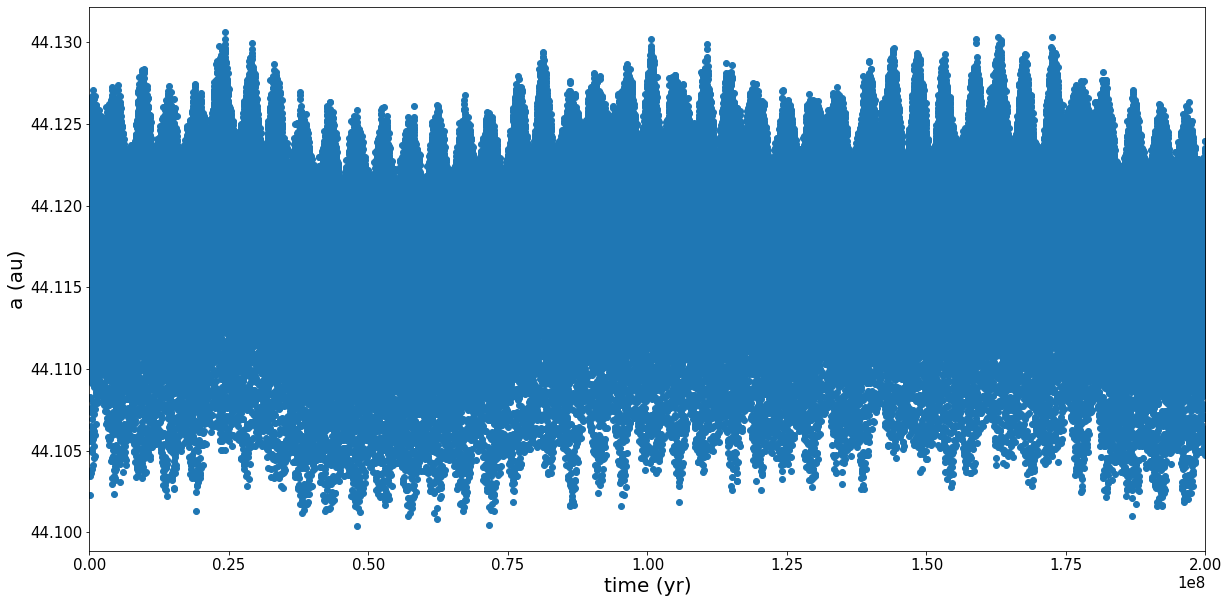

In [4]:
plt.scatter(t,a);
plt.ylabel('a (au)');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);


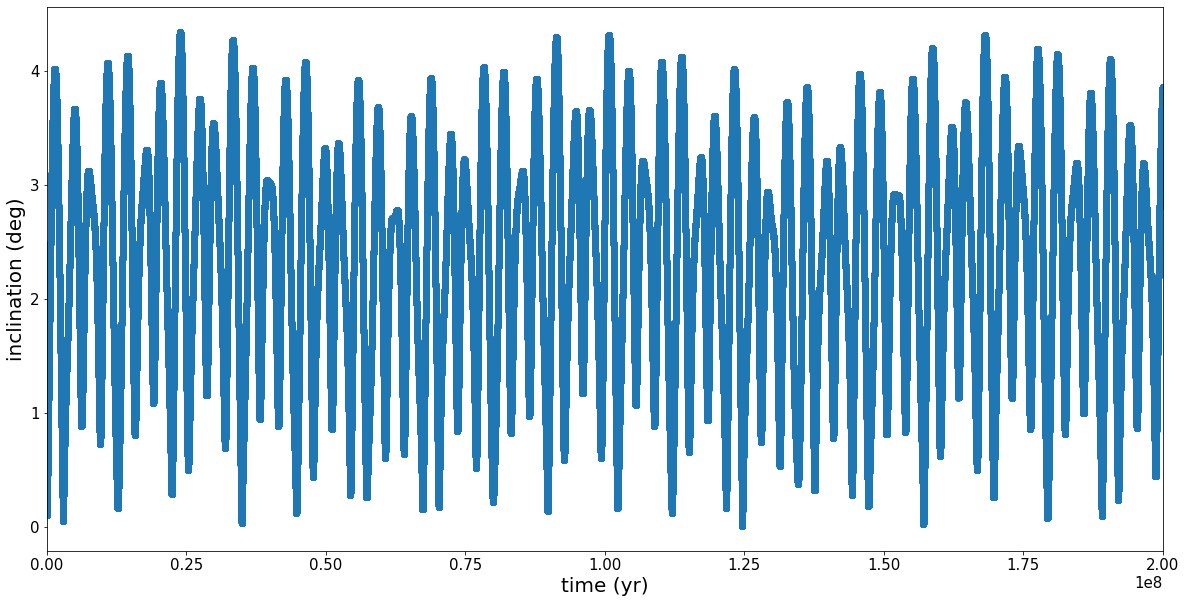

In [5]:
plt.scatter(t,inc);
plt.ylabel('inclination (deg)');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);

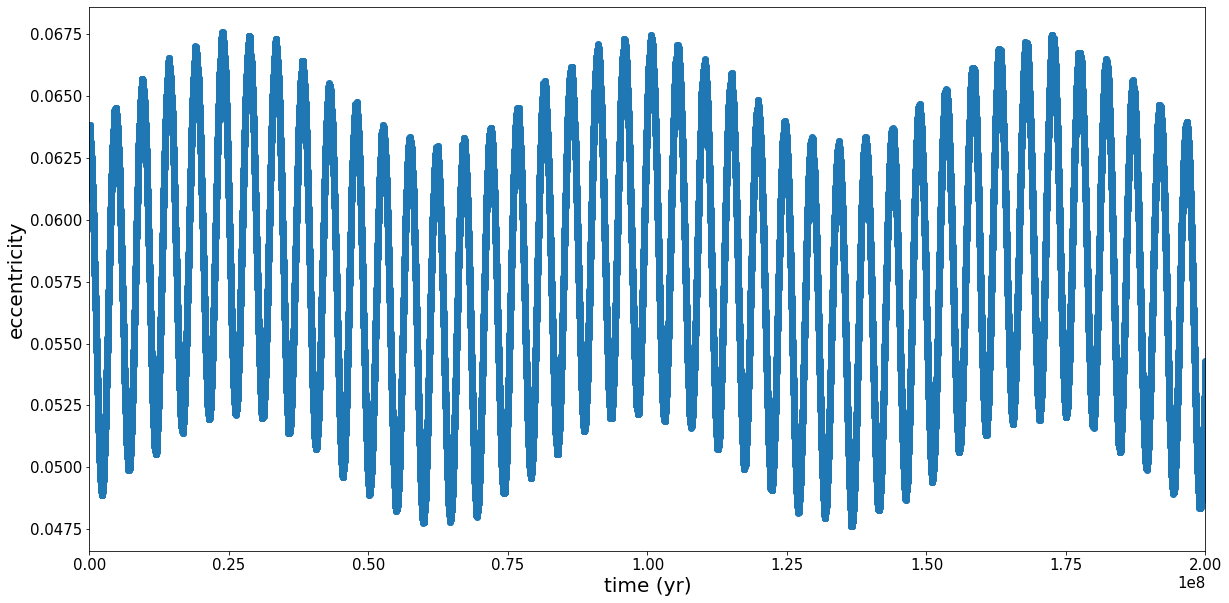

In [6]:
plt.scatter(t,e);
plt.ylabel('eccentricity');
plt.xlabel('time (yr)');
plt.xlim([0,t[-1]]);

In [7]:
print(freq)
print(int(Ylen/2))
print(freq[int(Ylen/2)+1])

[ 0.00000000e+00  4.99998750e-09  9.99997500e-09 ... -1.49999625e-08
 -9.99997500e-09 -4.99998750e-09]
200000
-0.00099999750000625


do all the FFTs for the inclination and eccentricity vectors

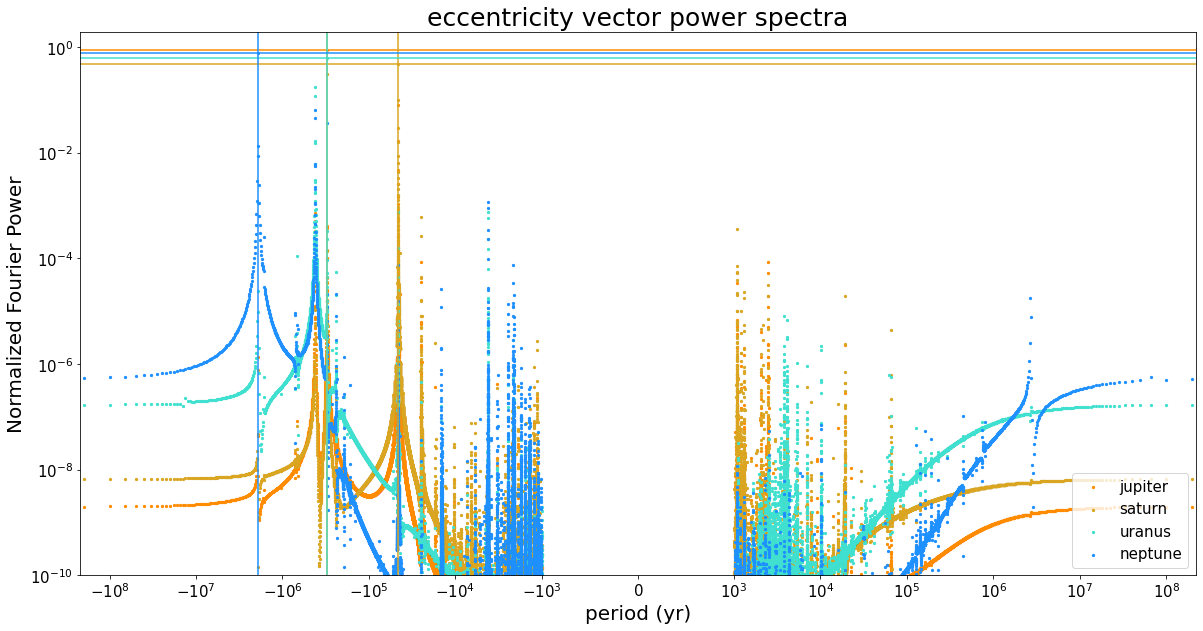

In [8]:
#plot the eccentricity spectra

#with terrestrial planets
#colors = ['khaki','b','r','darkorange','goldenrod','turquoise','dodgerblue']
#labels = ['venus','earth','mars','jupiter','saturn','uranus','neptune']

#without terrestrial planets
colors = ['darkorange','goldenrod','turquoise','dodgerblue']
labels = ['jupiter','saturn','uranus','neptune']

for n in range(0,npl):    
    plt.scatter(1/freq[1:],npYe_pl[1:,n],label=labels[n],c=colors[n],s=5)
    plt.axvline(x=1/freq[int(ie_pl_max[n])],c=colors[n])
    plt.axhline(y=npYe_pl[int(ie_pl_max[n]),n],c=colors[n])

#plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k',s=15)
plt.title('eccentricity vector power spectra',fontsize=25)


#plt.axvline(x=6.3e5/(2.),c='k')




#plt.axhline(y=pth*humax,c='g')
#plt.axhline(y=pth*hjmax,c='r')
#plt.axhline(y=pth*hsmax,c='goldenrod')
#plt.axhline(y=pth*hnmax,c='b')

plt.legend(loc='lower right')

plt.xlabel('period (yr)')
plt.ylabel('Normalized Fourier Power')
plt.yscale('log')
plt.xscale('symlog',linthresh=1/freq[int(Ylen/2)])
#maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([1e-10,2.]);
eplot = objname + "-e-spectrum-period.png"
plt.savefig(eplot,dpi=600)

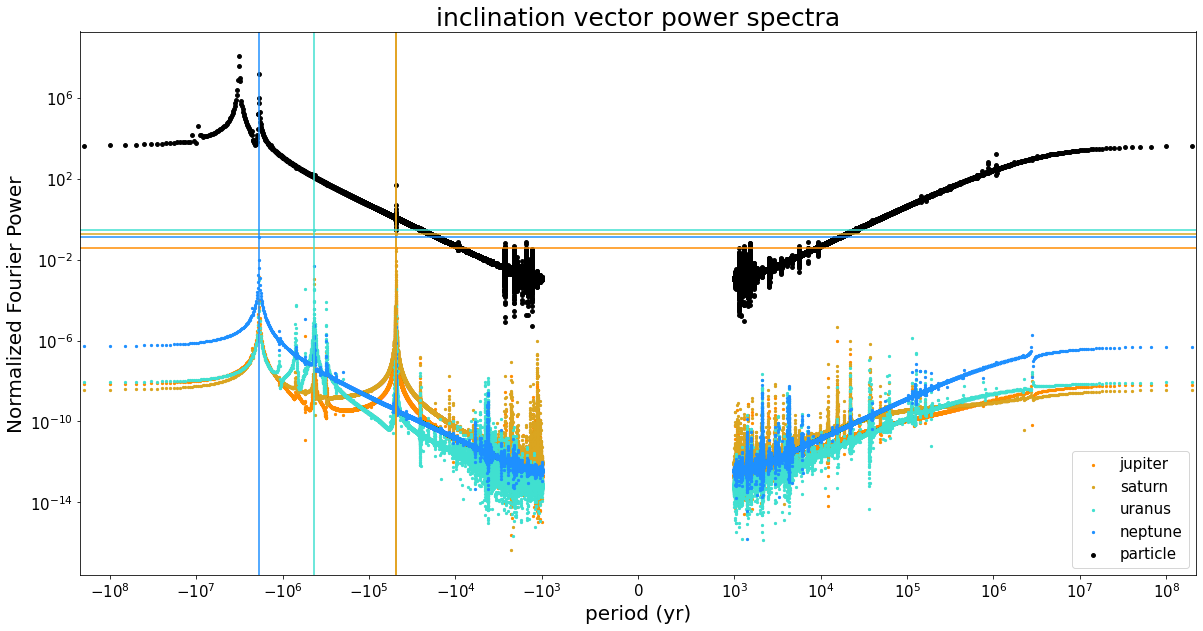

In [63]:
#plot the eccentricity spectra

#with terrestrial planets
#colors = ['khaki','b','r','darkorange','goldenrod','turquoise','dodgerblue']
#labels = ['venus','earth','mars','jupiter','saturn','uranus','neptune']

#without terrestrial planets
colors = ['darkorange','goldenrod','turquoise','dodgerblue']
labels = ['jupiter','saturn','uranus','neptune']

for n in range(0,npl):    
    plt.scatter(1/freq[1:],npYi_pl[1:,n],label=labels[n],c=colors[n],s=5)
    plt.axvline(x=1/freq[int(ii_pl_max[n])],c=colors[n])
    plt.axhline(y=npYi_pl[int(ii_pl_max[n]),n],c=colors[n])

plt.scatter(1/freq[1:],pYi[1:],label='particle',c='k',s=15)
plt.title('inclination vector power spectra',fontsize=25)


#plt.axvline(x=6.3e5/(2.),c='k')




#plt.axhline(y=pth*humax,c='g')
#plt.axhline(y=pth*hjmax,c='r')
#plt.axhline(y=pth*hsmax,c='goldenrod')
#plt.axhline(y=pth*hnmax,c='b')

plt.legend(loc='lower right')

plt.xlabel('period (yr)')
plt.ylabel('Normalized Fourier Power')
plt.yscale('log')
plt.xscale('symlog',linthresh=1/freq[int(Ylen/2)])
#maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

#plt.ylim([1e-14,2.]);
eplot = objname + "-i-spectrum-period.png"
plt.savefig(eplot,dpi=600)

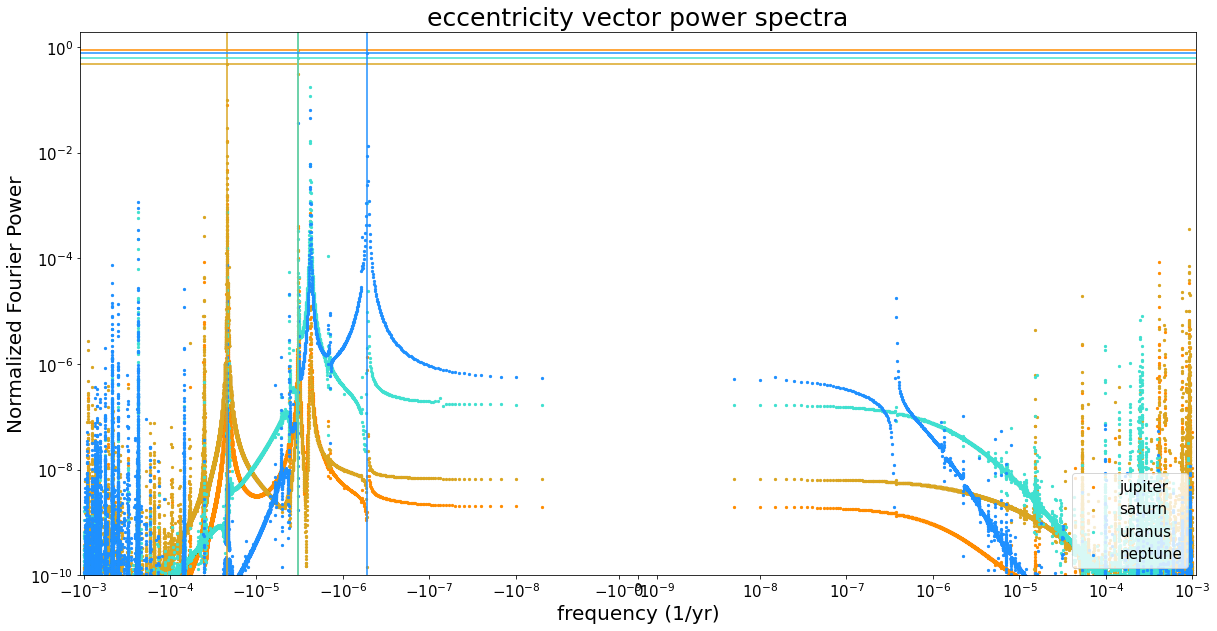

In [9]:
#plot the eccentricity spectra

#with terrestrial planets
#colors = ['khaki','b','r','darkorange','goldenrod','turquoise','dodgerblue']
#labels = ['venus','earth','mars','jupiter','saturn','uranus','neptune']

#without terrestrial planets
colors = ['darkorange','goldenrod','turquoise','dodgerblue']
labels = ['jupiter','saturn','uranus','neptune']

for n in range(0,npl):    
    plt.scatter(freq[1:],npYe_pl[1:,n],label=labels[n],c=colors[n],s=5)
    plt.axvline(x=freq[int(ie_pl_max[n])],c=colors[n])
    plt.axhline(y=npYe_pl[int(ie_pl_max[n]),n],c=colors[n])

#plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k',s=15)
plt.title('eccentricity vector power spectra',fontsize=25)


#plt.axvline(x=6.3e5/(2.),c='k')




#plt.axhline(y=pth*humax,c='g')
#plt.axhline(y=pth*hjmax,c='r')
#plt.axhline(y=pth*hsmax,c='goldenrod')
#plt.axhline(y=pth*hnmax,c='b')

plt.legend(loc='lower right')

plt.xlabel('frequency (1/yr)')
plt.ylabel('Normalized Fourier Power')
plt.yscale('log')
plt.xscale('symlog',linthresh=-freq[-1])
#maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([1e-10,2.]);
eplot = objname + "-e-spectrum-frequency.png"
plt.savefig(eplot,dpi=600)

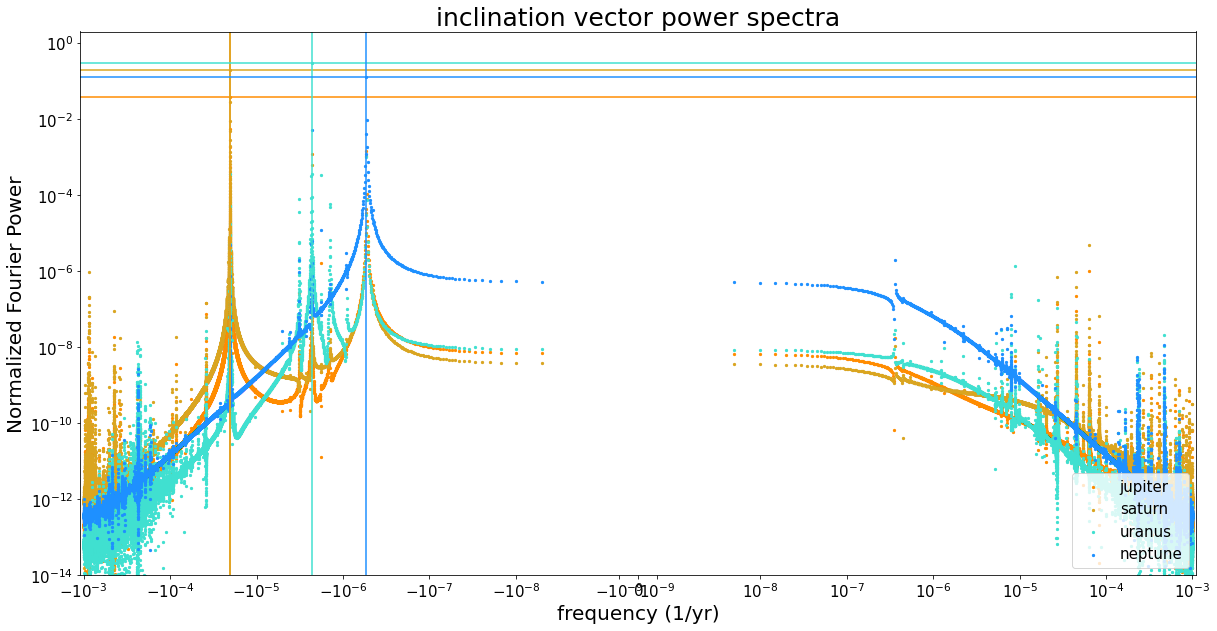

In [14]:
#plot the eccentricity spectra

#with terrestrial planets
#colors = ['khaki','b','r','darkorange','goldenrod','turquoise','dodgerblue']
#labels = ['venus','earth','mars','jupiter','saturn','uranus','neptune']

#without terrestrial planets
colors = ['darkorange','goldenrod','turquoise','dodgerblue']
labels = ['jupiter','saturn','uranus','neptune']

for n in range(0,npl):    
    plt.scatter(freq[1:],npYi_pl[1:,n],label=labels[n],c=colors[n],s=5)
    plt.axvline(x=freq[int(ii_pl_max[n])],c=colors[n])
    plt.axhline(y=npYi_pl[int(ii_pl_max[n]),n],c=colors[n])

#plt.scatter(1/freq[1:],pYh[1:],label='particle',c='k',s=15)
plt.title('inclination vector power spectra',fontsize=25)


#plt.axvline(x=6.3e5/(2.),c='k')




#plt.axhline(y=pth*humax,c='g')
#plt.axhline(y=pth*hjmax,c='r')
#plt.axhline(y=pth*hsmax,c='goldenrod')
#plt.axhline(y=pth*hnmax,c='b')

plt.legend(loc='lower right')

plt.xlabel('frequency (1/yr)')
plt.ylabel('Normalized Fourier Power')
plt.yscale('log')
plt.xscale('symlog',linthresh=-freq[-1])
#maxp = np.max([humax,hsmax,hjmax,hnmax,pYh[1:].max()])

plt.ylim([1e-14,2.]);
eplot = objname + "-i-spectrum-frequency.png"
plt.savefig(eplot,dpi=600)

In [15]:
from scipy.signal import kaiserord, lfilter, firwin, freqz

In [16]:
sample_rate = 1./dt
print(sample_rate)
nyq_rate = sample_rate / 2.0
print(nyq_rate)
print(freq[int(ie_pl_max[3])])

0.002
0.001
-5.1999870000325e-07


In [17]:
width = -freq[int(ii_pl_max[3])]*2/3./nyq_rate
ripple_db = 43.0
N, beta = kaiserord(ripple_db, width)
print(N)
print(width)
delay = 0.5 * (N-1) / sample_rate
print("%e" %delay)

13691
0.00035666577500222915
3.422500e+06


In [18]:
print(freq[int(ii_pl_max[3])]/nyq_rate)

-0.0005349986625033438


In [19]:
print(-freq[int(ii_pl_max[3])]/nyq_rate-1.*width, -freq[int(ii_pl_max[3])]/nyq_rate+2.*width,
              -freq[int(ii_pl_max[2])]/nyq_rate-2.*width, -freq[int(ii_pl_max[2])]/nyq_rate+2.*width,
              -freq[int(ii_pl_max[1])]/nyq_rate-2.*width, -freq[int(ii_pl_max[1])]/nyq_rate+2.*width)

0.00017833288750111466 0.0012483302125078021 0.0015966626750099793 0.003023325775018896 0.019611617637622574 0.021038280737631494


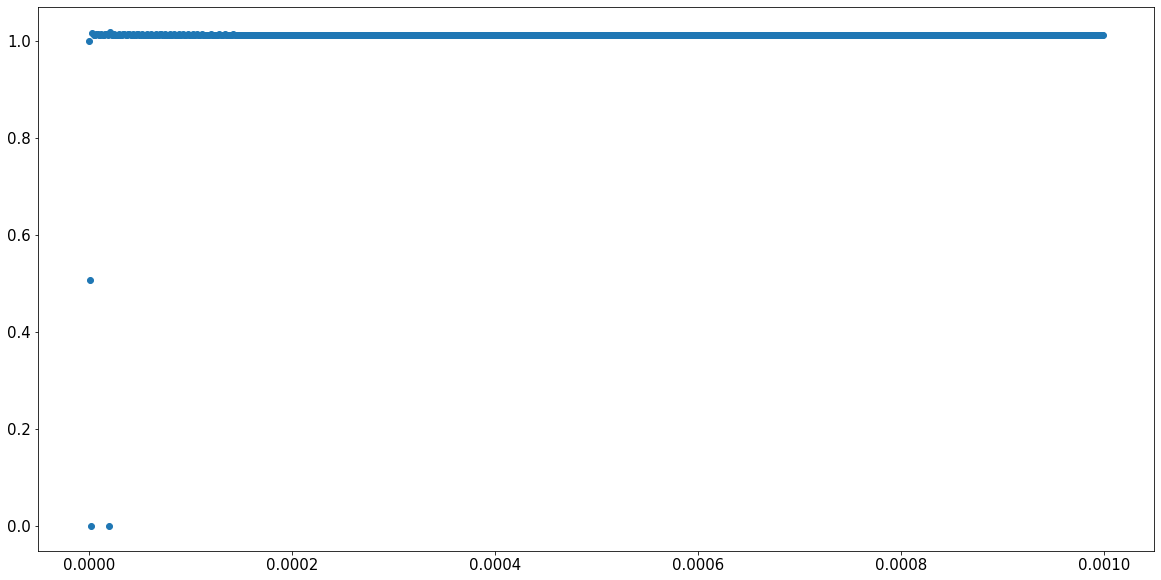

In [20]:

taps = firwin(N, [
                -freq[int(ii_pl_max[3])]/nyq_rate-1.*width, -freq[int(ii_pl_max[3])]/nyq_rate+2.*width,
              -freq[int(ii_pl_max[2])]/nyq_rate-2.*width, -freq[int(ii_pl_max[2])]/nyq_rate+2.*width,
              -freq[int(ii_pl_max[1])]/nyq_rate-2.*width, -freq[int(ii_pl_max[1])]/nyq_rate+2.*width],
              window=('kaiser', beta))



w, h = freqz(taps, worN=800)
plt.scatter(w/np.pi*nyq_rate, np.abs(h))
#plt.xscale('log')

In [21]:
filtered_ev = lfilter(taps, 1.0, qp)

f_q = lfilter(taps, 1.0, qtp)
f_p = lfilter(taps, 1.0, ptp)

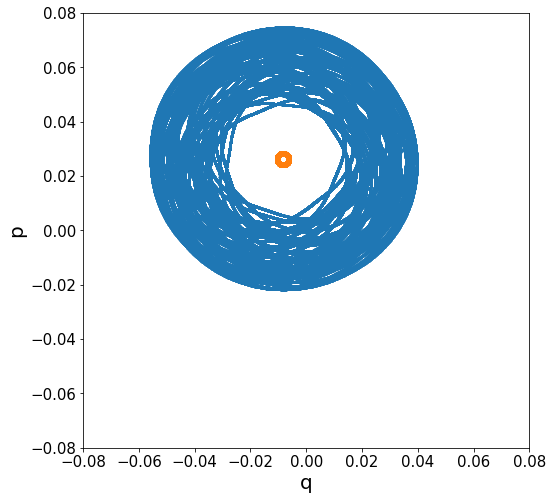

In [60]:
#plt.scatter(qp.real,qp.imag)
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(qtp[N-1:],ptp[N-1:],s=2)
plt.scatter(f_q[N-1:],f_p[N-1:],s=2)
plt.xlabel('q');
plt.ylabel('p');
plt.xlim([-0.08,0.08]);
plt.ylim([-0.08,0.08]);


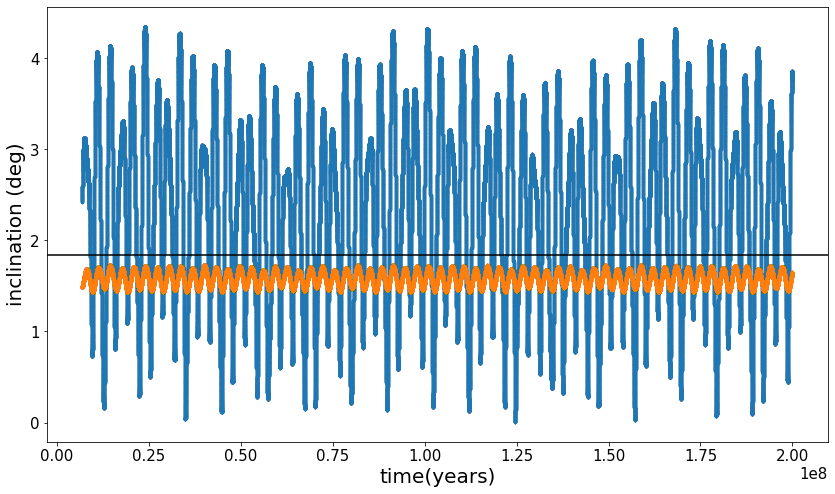

In [56]:
plt.rcParams["figure.figsize"] = (14, 8)


plt.scatter(t[N-1:],inc[N-1:],s=5)

plt.scatter(t[N-1:],
            180./np.pi*np.arcsin(np.sqrt( (f_q[N-1:])**2. 
            + (f_p[N-1:])**2.)),s=5 )
plt.axhline(y=1.8382,c='k')
plt.xlabel('time(years)');
plt.ylabel('inclination (deg)');

try a simple filter to zero out the planet frequencies

In [ ]:
#make copies of the FFT outputs
Yp_f = Yp.copy()
Yq_f = Yq.copy()
Yh_f = Yh.copy()
Yk_f = Yk.copy()

imax = len(Yp)
#disregard antyhing with a period shorter than 5000 years
freqlim = 1./5000.
#disregard frequencies for which any planet has power at higher than 10% the max
pth = 0.01


for i in range(0,imax):
    for n in range (0,npl):
    
        if (pYp_pl[i,n]>pth*pYp_pl_max[n] or freq[i]>freqlim):
            Yp_f[i]=0
        if (pYq_pl[i,n]>pth*pYq_pl_max[n] or freq[i]>freqlim):
            Yq_f[i]=0
        if (pYh_pl[i,n]>pth*pYh_pl_max[n] or freq[i]>freqlim):
            Yh_f[i]=0
        if (pYk_pl[i,n]>pth*pYk_pl_max[n] or freq[i]>freqlim):
            Yk_f[i]=0
    
p_f = np.fft.irfft(Yp_f,len(p))
q_f = np.fft.irfft(Yq_f,len(q))
h_f = np.fft.irfft(Yh_f,len(h))
k_f = np.fft.irfft(Yk_f,len(k))



sini = np.sqrt(p*p+q*q)
sini_f = np.sqrt(p_f*p_f + q_f*q_f)
ecc = np.sqrt(h*h+k*k)
ecc_f = np.sqrt(h_f*h_f + k_f*k_f)

In [ ]:
#plot p,q
#note: not sure why there are stray dots not on the circle
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(p,q,label='osculating');
plt.scatter(p_f,q_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('p');
plt.xlabel('q');
plt.legend();
plt.savefig("pq-filtered.png",dpi=600)


In [ ]:
#plot h,k
#note: not sure why there are stray dots not on the circle
plt.scatter(h,k,label='osculating');
plt.scatter(h_f,k_f,s=10,label='filtered');
plt.axhline(y=0,c='k');
plt.axvline(x=0,c='k');
plt.xlabel('h');
plt.xlabel('k');
plt.legend();
plt.rcParams["figure.figsize"] = (20, 10)
plt.savefig("pq-filtered.png",dpi=600)

the inclination filtering does get close-ish to the proper value, eccentricity one didn't do much of anything

In [ ]:
#plot oscuilating and filtered sini
plt.scatter(t,sini,s=5,label='osculating');
plt.scatter(t,sini_f,s=0.5,label='filtered');
#plot the range from Huang et al for this object
#plt.axhline(y=np.sin(11.2669*np.pi/180),c='k',label='analytical proper sini range');
#plt.axhline(y=np.sin(11.4669*np.pi/180),c='k');
#plt.axhline(y=np.sin(11.0669*np.pi/180),c='k');
plt.xlabel('time(years)');
plt.ylabel('sin(i)');
plt.legend();

plt.xlim([0,t[-1]]);

In [ ]:
#plot oscuilating and filtered eccentrcicity
plt.scatter(t,ecc,s=5,label='osculating');
plt.scatter(t,ecc_f,s=0.5,label='filtered');

plt.xlabel('time(years)');
plt.ylabel('eccentricity');
plt.legend();

plt.xlim([0,t[-1]]);
plt.ylim([ecc.min()-0.01,ecc.max()+0.01]);

# below here are some random attempts with filters from the scipy signal package

In [ ]:
fc, Pxyc = signal.csd(p, ppl[:,4], fs=1./dt,nperseg=len(freq))
plt.scatter(1/fc, np.abs(Pxyc))
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e3,1e7])

In [ ]:

quality_factor = 3.
nmax = len(freq)
filt = freq[ipnmax]
print(1/freq[ipnmax])
fs = 1/500.

b_f, a_f = signal.iirnotch(filt,quality_factor,fs=fs)

alt_f_p = signal.filtfilt(b_f, a_f, p)
alt_f_q = signal.filtfilt(b_f, a_f, q)


tY = np.fft.rfft(alt_f_p)
ptY = np.abs(tY)

ffreq, fh = signal.freqz(b_f,a_f, fs=2.*np.pi,worN=nmax);

plt.scatter(ffreq*fs/(2.*np.pi), np.abs(fh),
         c='r', label='Bandpass filter');

plt.scatter(freq, pYp,
         c='b', label='before filtering')
plt.scatter(freq, ptY,
         c='g', label='after filtering');

plt.legend();
 
plt.xlabel('Frequency [yr^{-1}]', fontsize=20);
plt.ylabel('Magnitude [dB]', fontsize=20);
plt.xscale('log');
plt.yscale('log');
plt.title('Notch Filter', fontsize=20);

In [ ]:
alt_i_filtered = np.sqrt(alt_f_q*alt_f_q + alt_f_p*alt_f_p)

plt.scatter(p,q)
plt.scatter(alt_f_p,alt_f_q,s=0.9)
plt.axhline(y=0)
plt.axvline(x=0)
print(alt_i_filtered)




In [ ]:
plt.scatter(t,sini,s=5,label='osculating')
plt.scatter(t,alt_i_filtered,s=0.05,label='filtered')
#plt.axhline(y=np.sin(11.2669*np.pi/180))
#plt.axhline(y=np.sin(11.4669*np.pi/180))
#plt.axhline(y=np.sin(11.0669*np.pi/180))
plt.xlabel('time(years)')
plt.ylabel('sin(i)')
plt.legend()



#plt.xlim([0,1e8])

In [ ]:
#set up all the FFT power spectra, etc
#the outputs are not exact, but it's about 
fimax = 2000
n = len(h)
freq = np.fft.rfftfreq(n,d=dt)

#particle eccentricity vectors
Yh= np.fft.rfft(k)
Yk = np.fft.rfft(h)

#giant planets
Yhu = np.fft.rfft(hu)
Yhj = np.fft.rfft(hj)
Yhn = np.fft.rfft(hn)
Yhs = np.fft.rfft(hs)
Yku = np.fft.rfft(ku)
Ykj = np.fft.rfft(kj)
Ykn = np.fft.rfft(kn)
Yks = np.fft.rfft(ks)

#convert to power
pYh = np.abs(Yh)**2.*freq*freq#/(np.abs(Yh[0])**2.)
pYk = np.abs(Yk)**2.*freq*freq#/(np.abs(Yk[0])**2.)
pYhu = np.abs(Yhu)**2.*freq*freq#/(np.abs(Yhu[0])**2.)
pYhn = np.abs(Yhn)**2.*freq*freq#/(np.abs(Yhn[0])**2.)
pYhj = np.abs(Yhj)**2.*freq*freq#/(np.abs(Yhj[0])**2.)
pYhs = np.abs(Yhs)**2.*freq*freq#/(np.abs(Yhs[0])**2.)
pYku = np.abs(Yku)**2.*freq*freq#/(np.abs(Yku[0])**2.)
pYkn = np.abs(Ykn)**2.*freq*freq#/(np.abs(Ykn[0])**2.)
pYkj = np.abs(Ykj)**2.*freq*freq#/(np.abs(Ykj[0])**2.)
pYks = np.abs(Yks)**2.*freq*freq#/(np.abs(Yks[0])**2.)


#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
kumax = pYku[1:fimax].max()
knmax = pYkn[1:fimax].max()
ksmax = pYks[1:fimax].max()
kjmax = pYkj[1:fimax].max()
humax = pYhu[1:fimax].max()
hnmax = pYhn[1:fimax].max()
hsmax = pYhs[1:fimax].max()
hjmax = pYhj[1:fimax].max()

#(these need the plus 1 to account for neglecting the f=0 term)
ihumax = np.argmax(pYhu[1:fimax])+1
ihnmax = np.argmax(pYhn[1:fimax])+1 
ihsmax = np.argmax(pYhs[1:fimax])+1 
ihjmax = np.argmax(pYhj[1:fimax])+1 
ikumax = np.argmax(pYku[1:fimax])+1 
iknmax = np.argmax(pYkn[1:fimax])+1
iksmax = np.argmax(pYks[1:fimax])+1
ikjmax = np.argmax(pYkj[1:fimax])+1 



#particle inclination vectors
Yp= np.fft.rfft(p)
Yq = np.fft.rfft(q)
#giant planets
Ypu = np.fft.rfft(pu)
Ypj = np.fft.rfft(pj)
Ypn = np.fft.rfft(pn)
Yps = np.fft.rfft(ps)
Yqu = np.fft.rfft(qu)
Yqj = np.fft.rfft(qj)
Yqn = np.fft.rfft(qn)
Yqs = np.fft.rfft(qs)

#convert to power
pYp = np.abs(Yp)**2.*freq*freq#/(np.abs(Yp[0])**2.)
pYpu = np.abs(Ypu)**2.*freq*freq#/(np.abs(Ypu[0])**2.)
pYpn = np.abs(Ypn)**2.*freq*freq#/(np.abs(Ypn[0])**2.)
pYpj = np.abs(Ypj)**2.*freq*freq#/(np.abs(Ypj[0])**2.)
pYps = np.abs(Yps)**2.*freq*freq#/(np.abs(Yps[0])**2.)
pYqu = np.abs(Yqu)**2.*freq*freq#/(np.abs(Yqu[0])**2.)
pYqn = np.abs(Yqn)**2.*freq*freq#/(np.abs(Yqn[0])**2.)
pYqj = np.abs(Yqj)**2.*freq*freq#/(np.abs(Yqj[0])**2.)
pYqs = np.abs(Yqs)**2.*freq*freq#/(np.abs(Yqs[0])**2.)




#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
pumax = pYpu[1:fimax].max()
pnmax = pYpn[1:fimax].max()
psmax = pYps[1:fimax].max()
pjmax = pYpj[1:fimax].max()
qumax = pYqu[1:fimax].max()
qnmax = pYqn[1:fimax].max()
qsmax = pYqs[1:fimax].max()
qjmax = pYqj[1:fimax].max()


ipumax = np.argmax(pYpu[1:fimax])+1
ipnmax = np.argmax(pYpn[1:fimax])+1 
ipsmax = np.argmax(pYps[1:fimax])+1 
ipjmax = np.argmax(pYpj[1:fimax])+1 
iqumax = np.argmax(pYqu[1:fimax])+1 
iqnmax = np.argmax(pYqn[1:fimax])+1
iqsmax = np.argmax(pYqs[1:fimax])+1
iqjmax = np.argmax(pYqj[1:fimax])+1 


print("peak planet eccentricity periods (years):")
print("Jupiter %f" % (1/freq[ikjmax]))
print("Saturn %f" % (1/freq[iksmax]))
print("Uranus %f" % (1/freq[ikumax]))
print("Neptune %f" % (1/freq[iknmax]))
print("peak power:")
print("Jupiter %e" % (hjmax))
print("Saturn %e" % (hsmax))
print("Uranus %e" % (humax))
print("Neptune %e" % (hnmax))



In [ ]:
#set up all the FFT power spectra, etc
#the outputs are not exact, but it's about 
fimax = 2000
n = len(h)
freq = np.fft.rfftfreq(n,d=dt)

#particle eccentricity vectors
Yh= np.fft.rfft(k)
Yk = np.fft.rfft(h)

#giant planets
Yhu = np.fft.rfft(hu)
Yhj = np.fft.rfft(hj)
Yhn = np.fft.rfft(hn)
Yhs = np.fft.rfft(hs)
Yku = np.fft.rfft(ku)
Ykj = np.fft.rfft(kj)
Ykn = np.fft.rfft(kn)
Yks = np.fft.rfft(ks)

#convert to power
pYh = np.abs(Yh)**2.*freq*freq#/(np.abs(Yh[0])**2.)
pYk = np.abs(Yk)**2.*freq*freq#/(np.abs(Yk[0])**2.)
pYhu = np.abs(Yhu)**2.*freq*freq#/(np.abs(Yhu[0])**2.)
pYhn = np.abs(Yhn)**2.*freq*freq#/(np.abs(Yhn[0])**2.)
pYhj = np.abs(Yhj)**2.*freq*freq#/(np.abs(Yhj[0])**2.)
pYhs = np.abs(Yhs)**2.*freq*freq#/(np.abs(Yhs[0])**2.)
pYku = np.abs(Yku)**2.*freq*freq#/(np.abs(Yku[0])**2.)
pYkn = np.abs(Ykn)**2.*freq*freq#/(np.abs(Ykn[0])**2.)
pYkj = np.abs(Ykj)**2.*freq*freq#/(np.abs(Ykj[0])**2.)
pYks = np.abs(Yks)**2.*freq*freq#/(np.abs(Yks[0])**2.)


#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
kumax = pYku[1:fimax].max()
knmax = pYkn[1:fimax].max()
ksmax = pYks[1:fimax].max()
kjmax = pYkj[1:fimax].max()
humax = pYhu[1:fimax].max()
hnmax = pYhn[1:fimax].max()
hsmax = pYhs[1:fimax].max()
hjmax = pYhj[1:fimax].max()

#(these need the plus 1 to account for neglecting the f=0 term)
ihumax = np.argmax(pYhu[1:fimax])+1
ihnmax = np.argmax(pYhn[1:fimax])+1 
ihsmax = np.argmax(pYhs[1:fimax])+1 
ihjmax = np.argmax(pYhj[1:fimax])+1 
ikumax = np.argmax(pYku[1:fimax])+1 
iknmax = np.argmax(pYkn[1:fimax])+1
iksmax = np.argmax(pYks[1:fimax])+1
ikjmax = np.argmax(pYkj[1:fimax])+1 



#particle inclination vectors
Yp= np.fft.rfft(p)
Yq = np.fft.rfft(q)
#giant planets
Ypu = np.fft.rfft(pu)
Ypj = np.fft.rfft(pj)
Ypn = np.fft.rfft(pn)
Yps = np.fft.rfft(ps)
Yqu = np.fft.rfft(qu)
Yqj = np.fft.rfft(qj)
Yqn = np.fft.rfft(qn)
Yqs = np.fft.rfft(qs)

#convert to power
pYp = np.abs(Yp)**2.*freq*freq#/(np.abs(Yp[0])**2.)
pYpu = np.abs(Ypu)**2.*freq*freq#/(np.abs(Ypu[0])**2.)
pYpn = np.abs(Ypn)**2.*freq*freq#/(np.abs(Ypn[0])**2.)
pYpj = np.abs(Ypj)**2.*freq*freq#/(np.abs(Ypj[0])**2.)
pYps = np.abs(Yps)**2.*freq*freq#/(np.abs(Yps[0])**2.)
pYqu = np.abs(Yqu)**2.*freq*freq#/(np.abs(Yqu[0])**2.)
pYqn = np.abs(Yqn)**2.*freq*freq#/(np.abs(Yqn[0])**2.)
pYqj = np.abs(Yqj)**2.*freq*freq#/(np.abs(Yqj[0])**2.)
pYqs = np.abs(Yqs)**2.*freq*freq#/(np.abs(Yqs[0])**2.)




#find the max power and indexes of that max power
#(disregarding the frequency=0 terms)
pumax = pYpu[1:fimax].max()
pnmax = pYpn[1:fimax].max()
psmax = pYps[1:fimax].max()
pjmax = pYpj[1:fimax].max()
qumax = pYqu[1:fimax].max()
qnmax = pYqn[1:fimax].max()
qsmax = pYqs[1:fimax].max()
qjmax = pYqj[1:fimax].max()


ipumax = np.argmax(pYpu[1:fimax])+1
ipnmax = np.argmax(pYpn[1:fimax])+1 
ipsmax = np.argmax(pYps[1:fimax])+1 
ipjmax = np.argmax(pYpj[1:fimax])+1 
iqumax = np.argmax(pYqu[1:fimax])+1 
iqnmax = np.argmax(pYqn[1:fimax])+1
iqsmax = np.argmax(pYqs[1:fimax])+1
iqjmax = np.argmax(pYqj[1:fimax])+1 


print("peak planet eccentricity periods (years):")
print("Jupiter %f" % (1/freq[ikjmax]))
print("Saturn %f" % (1/freq[iksmax]))
print("Uranus %f" % (1/freq[ikumax]))
print("Neptune %f" % (1/freq[iknmax]))
print("peak power:")
print("Jupiter %e" % (hjmax))
print("Saturn %e" % (hsmax))
print("Uranus %e" % (humax))
print("Neptune %e" % (hnmax))



In [ ]:
#(keep the space in sbody, it's a typo from when I ran it, but the hash has the space)\
#this will take a while, it's a 100 Myr integration with a 500 year output cadence
sbody = 'Ceres'
objname = 'Ceres'

path = 'TNOs/'+objname


#these arrays are all a bit of a mess, at some point would want to 
#change it to be a multi-dimensional array for the planets so they 
#don't all have to be handled by hand
a = np.zeros(1);e = np.zeros(1);inc = np.zeros(1);
p = np.zeros(1);q = np.zeros(1);h = np.zeros(1);k = np.zeros(1);
pu = np.zeros(1);qu = np.zeros(1);hu = np.zeros(1);ku = np.zeros(1);
pj = np.zeros(1);qj = np.zeros(1);hj = np.zeros(1);kj = np.zeros(1);
ps = np.zeros(1);qs = np.zeros(1);hs = np.zeros(1);ks = np.zeros(1);
pn = np.zeros(1);qn = np.zeros(1);hn = np.zeros(1);kn = np.zeros(1);
omega = np.zeros(1);
Omega = np.zeros(1);
M = np.zeros(1)
t = np.zeros(1);
sa = rebound.SimulationArchive("TNOs/"+objname+"/archive.bin")
print("start time %f" % sa.tmin)
print("stop time %f" % sa.tmax)

sim=sa[-1]

planets = ['venus','earth','mars','jupiter','saturn','uranus','neptune']
for i,sim in enumerate(sa):
    tp = sim.particles[sbody+"_bf"]
    nep = sim.particles["neptune"]
    ura = sim.particles["uranus"]
    sat = sim.particles["saturn"]
    jup = sim.particles["jupiter"]
    com = sim.calculate_com()
    o = tp.calculate_orbit(com)
    
    onep = nep.calculate_orbit(com)
    oura = ura.calculate_orbit(com)
    osat = sat.calculate_orbit(com)
    ojup = jup.calculate_orbit(com)

    t = np.append(t, sim.t)
    a = np.append(a, o.a)
    p = np.append(p, np.sin(o.inc)*np.sin(o.Omega))
    q = np.append(q, np.sin(o.inc)*np.cos(o.Omega))
    h = np.append(h, (o.e)*np.sin(o.Omega+o.omega))
    k = np.append(k, (o.e)*np.cos(o.Omega+o.omega))

    pj = np.append(pj, np.sin(ojup.inc)*np.sin(ojup.Omega))
    qj = np.append(qj, np.sin(ojup.inc)*np.cos(ojup.Omega))
    hj = np.append(hj, (ojup.e)*np.sin(ojup.Omega+ojup.omega))
    kj = np.append(kj, (ojup.e)*np.cos(ojup.Omega+ojup.omega))

    ps = np.append(ps, np.sin(osat.inc)*np.sin(osat.Omega))
    qs = np.append(qs, np.sin(osat.inc)*np.cos(osat.Omega))
    hs = np.append(hs, (osat.e)*np.sin(osat.Omega+osat.omega))
    ks = np.append(ks, (osat.e)*np.cos(osat.Omega+osat.omega))

    pu = np.append(pu, np.sin(oura.inc)*np.sin(oura.Omega))
    qu = np.append(qu, np.sin(oura.inc)*np.cos(oura.Omega))
    hu = np.append(hu, (oura.e)*np.sin(oura.Omega+oura.omega))
    ku = np.append(ku, (oura.e)*np.cos(oura.Omega+oura.omega))

    pn = np.append(pn, np.sin(onep.inc)*np.sin(onep.Omega))
    qn = np.append(qn, np.sin(onep.inc)*np.cos(onep.Omega))
    hn = np.append(hn, (onep.e)*np.sin(onep.Omega+onep.omega))
    kn = np.append(kn, (onep.e)*np.cos(onep.Omega+onep.omega))


    e = np.append(e, o.e)
    omega = np.append(omega, o.omega*180/np.pi)
    Omega = np.append(Omega, o.Omega*180/np.pi)
    M = np.append(M, o.M*180/np.pi)
    
    inc = np.append(inc, o.inc*180/np.pi)



t = np.delete(t,0)
a = np.delete(a,0)
e = np.delete(e,0)
inc = np.delete(inc,0)
omega = np.delete(omega,0)
Omega = np.delete(Omega,0)
M = np.delete(M,0)
h = np.delete(h,0)
k = np.delete(k,0)
p = np.delete(p,0)
q = np.delete(q,0)

hj = np.delete(hj,0)
kj = np.delete(kj,0)
pj = np.delete(pj,0)
qj = np.delete(qj,0)
hs = np.delete(hs,0)
ks = np.delete(ks,0)
ps = np.delete(ps,0)
qs = np.delete(qs,0)
hu = np.delete(hu,0)
ku = np.delete(ku,0)
pu = np.delete(pu,0)
qu = np.delete(qu,0)
hn = np.delete(hn,0)
kn = np.delete(kn,0)
pn = np.delete(pn,0)
qn = np.delete(qn,0)